# Deep neural nets for object recognition
In this exercise, you will first develop a fully connected neural net model and test it on the CIFAR-10 problem. Then, you will build a convolutional neural net model and test it on the same CIFAR-10 problem. The purpose of this part of the exercise is to give you a working understanding of neural net models and give you experience in tuning their (many) hyper-parameters.

Then, you will use a Resnet model pretrained on Imagenet and test its out-of-the-box performance on CIFAR-10. You will finetune the pretrained Resnet model on CIFAR-10 and test its performance on a set aside test set. Finally, you will use data augmentation and finetune the pretrained Resnet model with augmented data, and check its performance on a set aside test set.

You will then comment on performance differences between fully connected networks and CNNs trained from scratch on CIFAR-10, relative to the performance you saw with linear models (softmax, GDA and SVM). You will also comment on the use of finetuning pre-trained models and the role of data augmentation fine tuning large parameter models.

In [3]:
!pip install torchview

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
from torchview import draw_graph

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import copy

import torch.nn.functional as F # Import the functional module

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [68]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# Image size
img_size=224

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

torch.manual_seed(42)  # for reproducibility

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of training batches =  704
Number of validation batches =  79
Number of test batches =  157


# Visualize the training data

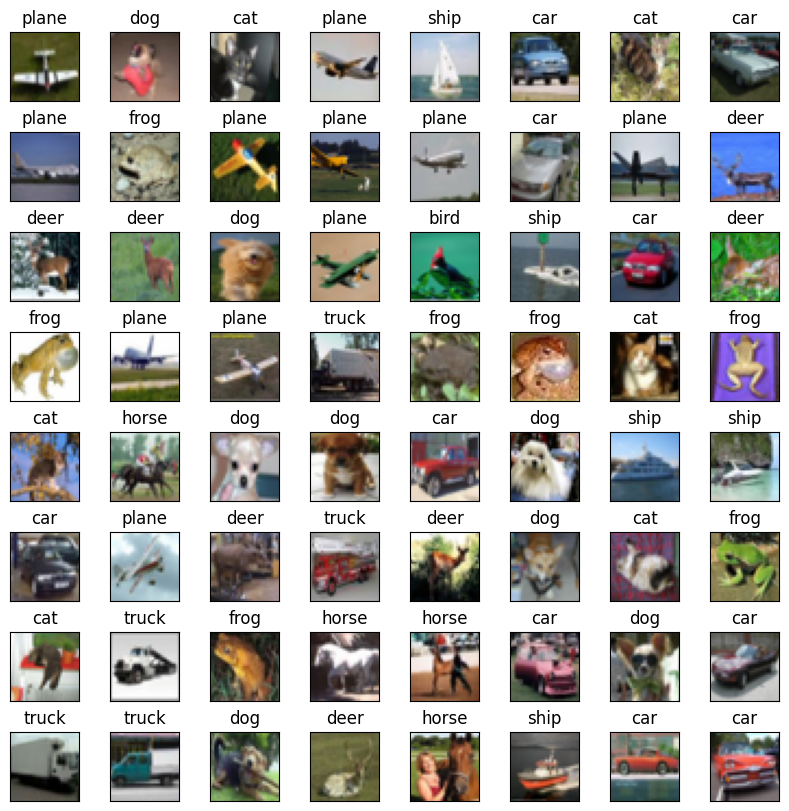

In [31]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# A five layer fully connected (FC) feedforward network (20 points)
- has an input layer, two hidden layers, and an output layer
- complete the function definitions below
- you will find d2l.ai Chapters 5.2, 5.6, 6.1, 6.2, 6.3 very useful

In [32]:
class FiveLayerFC(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes,lr,wd):
        super().__init__()
        # set up learning rate lr and weight decay wd
        # set up the network structure using nn.Sequential
        # use the ReLU non-linearity after all the hidden layers
        # use Xavier normal initialization for the weights in the hidden layers
        # use zero initialization for the bias weights
        # do not forget to Flatten the input before passing it to the first hidden layer
        ######## START YOUR CODE HERE (7-10 lines)
        self.lr = lr
        self.wd = wd

        # network: Flatten -> HL1 -> ReLU -> HL2 -> ReLU -> OL
        self.hl1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.hl2 = nn.Linear(hidden_size1, hidden_size2, bias=True) # will create nn.Parameter for weights and bias
        self.ol3 = nn.Linear(hidden_size2, num_classes, bias=True) # will create nn.Parameter for weights and bias

        self.net = nn.Sequential(
            nn.Flatten(),
            self.hl1,
            nn.ReLU(),
            self.hl2,
            nn.ReLU(),
            self.ol3
        )

        nn.init.xavier_normal_(self.hl1.weight)
        nn.init.xavier_normal_(self.hl2.weight)
        with torch.no_grad():  # don't need gradient of the initialization operation itself
            self.hl1.bias.zero_()
            self.hl2.bias.zero_()
            self.ol3.bias.zero_()
        ######## END YOUR CODE HERE

    def forward(self, x):
        # forward propagate the input x through the network
        # output should be a vector of dimension 10
        ######## START YOUR CODE HERE (1 line)
        return self.net(x)
        ######## END YOUR CODE HERE

    def loss(self,yhat,y,averaged=True):
        # use nn.functional.cross_entropy() to evaluate loss with prediction (yhat)
        # and truth (y). Average it over a batch.
        ######### START YOUR CODE HERE (1-2 lines)
        reduction = 'mean' if averaged else 'none'
        return F.cross_entropy(yhat, y, reduction=reduction)
        ######### END YOUR CODE HERE

    def predict(self,x):
       # propagate x forward and return the index of the
       # the highest valued output component
       ######## START YOUR CODE HERE (1 line)
       return self.forward(x).argmax(dim=1)
       ######### END YOUR CODE HERE

    def configure_optimizers(self):
        # set up the Adam optimizer with learning rate and weight decay specified
        # in the model object
        ######## START YOUR CODE HERE (1 line)
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        ######### END YOUR CODE HERE

# Test the FiveLayerFC class
- set the device to GPU if you have access to it.
- In Google Colab, you can select runtime, and pick the free T4 GPU choice.
- to understand how GPU memory and CPU memory interact, read Section 6.7 of the d2l.ai textbook.

Device is:  cuda
torch.Size([64, 10])


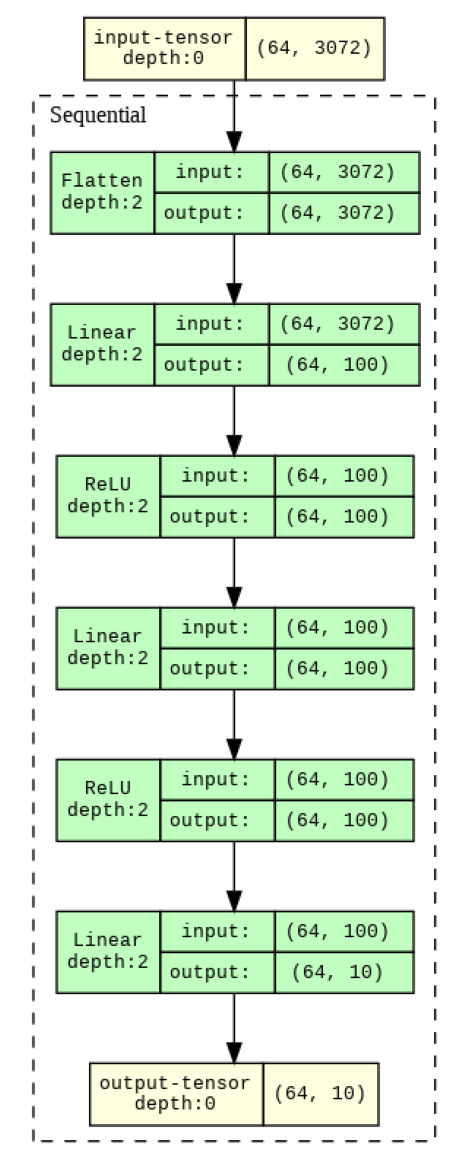

In [33]:
lr = 1e-2
wd = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

def test_FiveLayerFC(lr,wd):
    input_size = 32*32*3
    x = torch.zeros((64, input_size), dtype=torch.float).to(device)  # minibatch size 64, feature dimension 50
    model = FiveLayerFC(input_size, 100, 100,10,lr,wd).to(device)
    outputs = model(x)
    print(outputs.size())  # you should see [64, 10]
    model_graph = draw_graph(
        model,
        input_size=x.shape,
        expand_nested=True,
        save_graph=True,
        filename="my_Five_layer_FC_model",
        directory="./"
    )

test_FiveLayerFC(lr,wd)

# draw the model
plt.figure(figsize=(20, 15))
plt.imshow(mpimg.imread('my_Five_layer_FC_model.png'))
plt.axis('off') # Turn off axis numbers and ticks
plt.show()

# Checking the network setup (15 points)
As a sanity check, make sure you can overfit a small dataset of 64 images. We will use a five-layer network with 100 units in the two hidden layers. You will need to tweak the learning rate and weight decay, but you should be able to overfit and achieve 100% training accuracy within 20 epochs. We have given you parameter choices that work. You should report on at least another choice of learning rate and weight decay that allows you to fit the training data to 100% accuracy within 20 epochs.

Complete the function train_model_small that takes a single batch (Xtr,ytr) of 64 images and their labels for training, and a single batch (Xval,yval) of validation images and trains an initialized model for num_epochs epochs.

- Initialize train_loss and val_loss (which will hold training and validation set loss for each epoch)
- Configure optimizer for the model
- for epoch in range(num_epochs)
    - zero out gradients in the optimizer
    - compute output of network by forward propagating Xtr through network
    - compute loss using output and ytr
    - backpropagate the loss
    - store the training loss for this epoch
    - compute validation set loss for this epoch (remember to turn off gradient update with torch.no_grad())
- return model, train_loss and val_loss


In [61]:
Xtr,ytr = next(iter(trainloader))
Xval, yval = next(iter(valloader))
num_epochs = 20

# lr = 1e-2
# wd = 1e-3

lr = 1e-3
wd = 0

def train_model_small(model,Xtr,ytr,Xval,yval,num_epochs):

    ####### START YOUR CODE HERE (10-14 lines)
    train_loss, val_loss = [], []
    opt = model.configure_optimizers()
    for epoch in range(num_epochs):
      # train step on the single training batch
      model.train()
      opt.zero_grad() # clear gradient
      yhat = model(Xtr)
      loss = model.loss(yhat, ytr, averaged=True)
      loss.backward() #computes derivtives
      opt.step() # Adam updates params using grads from previous step
      train_loss.append(loss.item()) # store mean cross-entropy over the batch

      # validation loss on the single validation batch
      model.eval()
      with torch.no_grad():
          vloss = model.loss(model(Xval), yval, averaged=True)
      val_loss.append(vloss.item())

    ######## END YOUR CODE HERE

    return model,train_loss,val_loss

model = FiveLayerFC(32*32*3,100,100,10,lr,wd)
model,train_loss,val_loss = train_model_small(model,Xtr,ytr,Xval,yval,num_epochs)
torch.save(model.state_dict(), 'model_small.pth')


In [46]:
def plot_loss_curves(num_epochs,train_loss,val_loss):
   plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
   plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
   plt.title("Training and Validation Loss Curves")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()

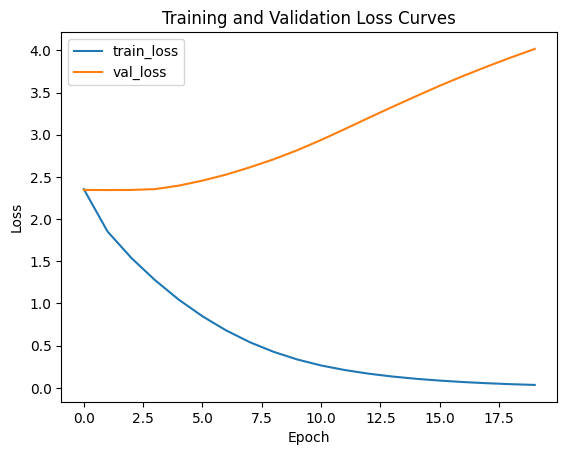

In [62]:
# plot the loss curve for the small model training

plot_loss_curves(num_epochs,train_loss,val_loss)

# Test your model on the training set
- you should get 100% accuracy

In [64]:
with torch.no_grad():
    ypred = model.predict(Xtr)

    cm = sklearn.metrics.confusion_matrix(ytr,ypred)
    acc = sklearn.metrics.accuracy_score(ytr,ypred)
    print('Accuracy on test set = ',acc)
    print(cm)
    print(sklearn.metrics.classification_report(ytr,ypred))

Accuracy on test set =  1.0
[[ 6  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6

    accuracy                           1.00  

# Train the full model (25 points)
- Initialize train_loss and val_loss (which will hold training and validation set loss for each epoch)
- Configure optimizer for the model
- for epoch in range(num_epochs)
    - for each batch (Xtr,ytr) in training set
       - zero out gradients in the optimizer
       - compute output of network by forward propagating Xtr through network
       - compute loss using output and ytr
       - backpropagate the loss
       - update the parameters with .step() on optimizer
       - accumulate the training loss for this batch
    - store training loss for this epoch
    - compute validation set loss for this epoch (remember to turn off gradient update with torch.no_grad()) and remember to iterate over all the batches of the validation set
    
- return model, train_loss and val_loss

In [77]:
def train_model(model,trainloader,valloader,num_epochs):
    ######## START YOUR CODE HERE (20-24 lines)
    train_loss, val_loss = [], []
    opt = model.configure_optimizers()
    device = next(model.parameters()).device # Get the device of the model

    for epoch in range(num_epochs):
        # train
        model.train()
        running_loss, n_seen = 0.0, 0
        for Xtr, ytr in trainloader:
            Xtr, ytr = Xtr.to(device), ytr.to(device) # Move data to the same device as the model
            opt.zero_grad()
            yhat = model(Xtr)
            loss = model.loss(yhat, ytr, averaged=True)  # mean over this batch
            loss.backward()
            opt.step()
            bs = ytr.size(0) # batch size
            running_loss += loss.item() * bs # just get sum for batch
            n_seen += bs
        train_loss.append(running_loss / max(1, n_seen))

        # val
        model.eval()
        v_running, v_seen = 0.0, 0
        with torch.no_grad():
            for Xval, yval in valloader:
                Xval, yval = Xval.to(device), yval.to(device) # Move data to the same device as the model
                vloss = model.loss(model(Xval), yval, averaged=True)
                bs = yval.size(0)
                v_running += vloss.item() * bs
                v_seen += bs
        val_loss.append(v_running / max(1, v_seen))
    ######## END YOUR CODE HERE
    return model,train_loss,val_loss

# Train and test performance of model
- hyperparameter choice: lr = 1e-5, weight_decay = 1e-2
- train the model using training and validation data
- get accuracy, confusion matrix and classification report on test data

In [78]:
# test a model with a testloader
# return an array of test images, true labels, predicted labels

def model_eval(model,testloader):
    X_test_list = [] # Use a list to store batches of test data
    with torch.no_grad():
        ys=[]
        outputs=[]
        for i, tdata in enumerate(testloader):
            tX,ty = tdata
            tX=tX.to(device)
            X_test_list.append(tX.detach().cpu().numpy())
            ty=ty.to(device)
            output = model.predict(tX)
            ys.append(ty.detach().cpu().numpy())
            outputs.append(output.detach().cpu().numpy())

    X_test = np.concatenate(X_test_list)
    ys=np.hstack(ys)
    outputs= np.hstack(outputs)
    cm = sklearn.metrics.confusion_matrix(ys,outputs)
    print("****************************************************************************************")
    print("performance report")
    print(sklearn.metrics.classification_report(ys,outputs))
    print("confusion matrix:")
    disp = sklearn.metrics.ConfusionMatrixDisplay(cm,display_labels=classes)
    disp.plot()
    return X_test,ys,outputs

****************************************************************************************
performance report
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1000
           1       0.57      0.64      0.60      1000
           2       0.39      0.32      0.35      1000
           3       0.35      0.38      0.36      1000
           4       0.44      0.35      0.39      1000
           5       0.41      0.35      0.38      1000
           6       0.49      0.56      0.52      1000
           7       0.53      0.55      0.54      1000
           8       0.57      0.64      0.61      1000
           9       0.52      0.55      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000

confusion matrix:


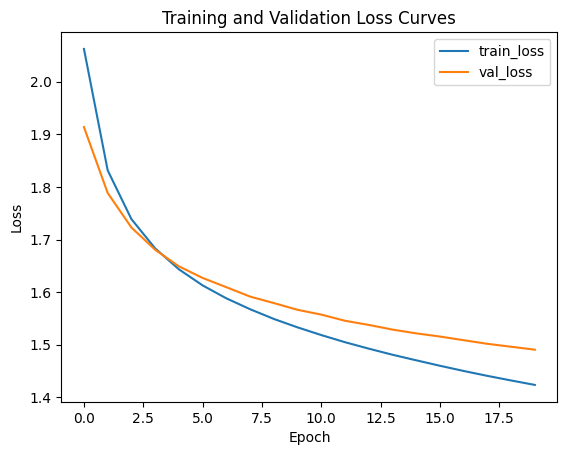

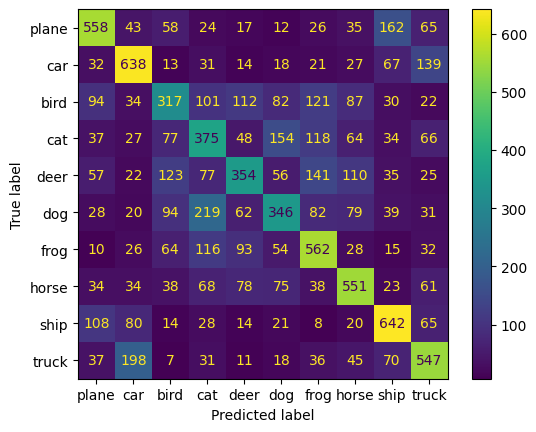

In [80]:
lr = 1e-5
wd = 1e-2
num_epochs = 20

model_mlp = FiveLayerFC(32*32*3,200,200,10,lr,wd).to(device)
model_mlp,train_loss,val_loss = train_model(model_mlp,trainloader,valloader,num_epochs)
torch.save(model_mlp.state_dict(), 'model_mlp.pth')

plot_loss_curves(num_epochs,train_loss,val_loss)
X_test, ys, outputs = model_eval(model_mlp,testloader) # Changed 'model' to 'model_mlp'

# Visualization of confusion matrix

In [81]:
# Some plot utilities

def denormalize(img):
    """Undo CIFAR-10 normalization and convert to uint8 for imshow."""
    img = np.transpose(img, (1, 2, 0))           # CHW -> HWC
    img = (img * tstd + tmean) * 255.0
    return np.clip(img, 0, 255).astype(np.uint8)

# Only use this for models in augmented data
def plot_confused_classes_aug(model, testloader, classes, cl_a, cl_b):
    X_aa_list = []
    X_ab_list = []
    X_ba_list = []
    X_bb_list = []

    with torch.no_grad():
        for X, y in testloader:
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            y_pred = torch.argmax(yhat, dim=1).to(device)

            # Filter images based on true and predicted labels
            X_aa_batch = X[(y == cl_a) & (y_pred == cl_a)]
            X_ab_batch = X[(y == cl_a) & (y_pred == cl_b)]
            X_ba_batch = X[(y == cl_b) & (y_pred == cl_a)]
            X_bb_batch = X[(y == cl_b) & (y_pred == cl_b)]

            X_aa_list.append(X_aa_batch.detach().cpu().numpy())
            X_ab_list.append(X_ab_batch.detach().cpu().numpy())
            X_ba_list.append(X_ba_batch.detach().cpu().numpy())
            X_bb_list.append(X_bb_batch.detach().cpu().numpy())

    X_aa = np.concatenate(X_aa_list) if X_aa_list else np.array([])
    X_ab = np.concatenate(X_ab_list) if X_ab_list else np.array([])
    X_ba = np.concatenate(X_ba_list) if X_ba_list else np.array([])
    X_bb = np.concatenate(X_bb_list) if X_bb_list else np.array([])

    size = 5   # grid size inside each confusion block
    pad = 0.5  # spacing between quadrants
    total = 2 * size + pad  # logical grid size

    fig = plt.figure(figsize=(size*2, size*2))

    # Loop through quadrants
    for images, (true_row, pred_col) in [
        (X_aa, (0, 0)),  # true A, pred A
        (X_ab, (0, 1)),  # true A, pred B
        (X_ba, (1, 0)),  # true B, pred A
        (X_bb, (1, 1)),  # true B, pred B
    ]:
        for idx, image_data in enumerate(images[:size*size]):
            # Grid position in "data units"
            x = idx % size + pred_col * (size + pad)
            y = idx // size + true_row * (size + pad)

            # Normalize to figure coords [0,1]
            ax = fig.add_axes([x / total,
                               y / total,
                               1 / total,
                               1 / total])

            img = denormalize(image_data)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])

    # Add invisible overlay axis (in figure space)
    ax_main = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_main.set_xticks([ (size/2)/total, (size+pad+size/2)/total ])
    ax_main.set_xticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

    ax_main.set_yticks([ (size/2)/total, (size+pad+size/2)/total ])
    ax_main.set_yticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

    ax_main.set_xlabel("Predicted label", fontsize=14)
    ax_main.set_ylabel("True label", fontsize=14)

    # Hide tick marks and spines
    ax_main.tick_params(axis='both', which='both', length=0)
    for spine in ax_main.spines.values():
        spine.set_visible(False)

    # Divider lines in normalized coords
    ax_main.plot([ (size+pad/2)/total, (size+pad/2)/total ], [0,1], "k:")
    ax_main.plot([0,1], [ (size+pad/2)/total, (size+pad/2)/total ], "k:")

    plt.show()

# use this for regular models with no data augmentation
def plot_confused_classes(X_test, all_y_true, all_y_pred, classes, cl_a, cl_b):
    X_aa = X_test[(all_y_true == cl_a) & (all_y_pred == cl_a)]
    X_ab = X_test[(all_y_true == cl_a) & (all_y_pred == cl_b)]
    X_ba = X_test[(all_y_true == cl_b) & (all_y_pred == cl_a)]
    X_bb = X_test[(all_y_true == cl_b) & (all_y_pred == cl_b)]

    size = 5   # grid size inside each confusion block
    pad = 0.5  # spacing between quadrants
    total = 2 * size + pad  # logical grid size

    fig = plt.figure(figsize=(size*2, size*2))

    # Loop through quadrants
    for images, (true_row, pred_col) in [
        (X_aa, (0, 0)),  # true A, pred A
        (X_ab, (0, 1)),  # true A, pred B
        (X_ba, (1, 0)),  # true B, pred A
        (X_bb, (1, 1)),  # true B, pred B
    ]:
        for idx, image_data in enumerate(images[:size*size]):
            # Grid position in "data units"
            x = idx % size + pred_col * (size + pad)
            y = idx // size + true_row * (size + pad)

            # Normalize to figure coords [0,1]
            ax = fig.add_axes([x / total,
                               y / total,
                               1 / total,
                               1 / total])

            img = denormalize(image_data)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])

       # Add invisible overlay axis (in figure space)
    ax_main = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_main.set_xticks([ (size/2)/total, (size+pad+size/2)/total ])
    ax_main.set_xticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

    ax_main.set_yticks([ (size/2)/total, (size+pad+size/2)/total ])
    ax_main.set_yticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

    ax_main.set_xlabel("Predicted label", fontsize=14)
    ax_main.set_ylabel("True label", fontsize=14)

    # Hide tick marks and spines
    ax_main.tick_params(axis='both', which='both', length=0)
    for spine in ax_main.spines.values():
        spine.set_visible(False)

    # Divider lines in normalized coords
    ax_main.plot([ (size+pad/2)/total, (size+pad/2)/total ], [0,1], "k:")
    ax_main.plot([0,1], [ (size+pad/2)/total, (size+pad/2)/total ], "k:")

    plt.show()

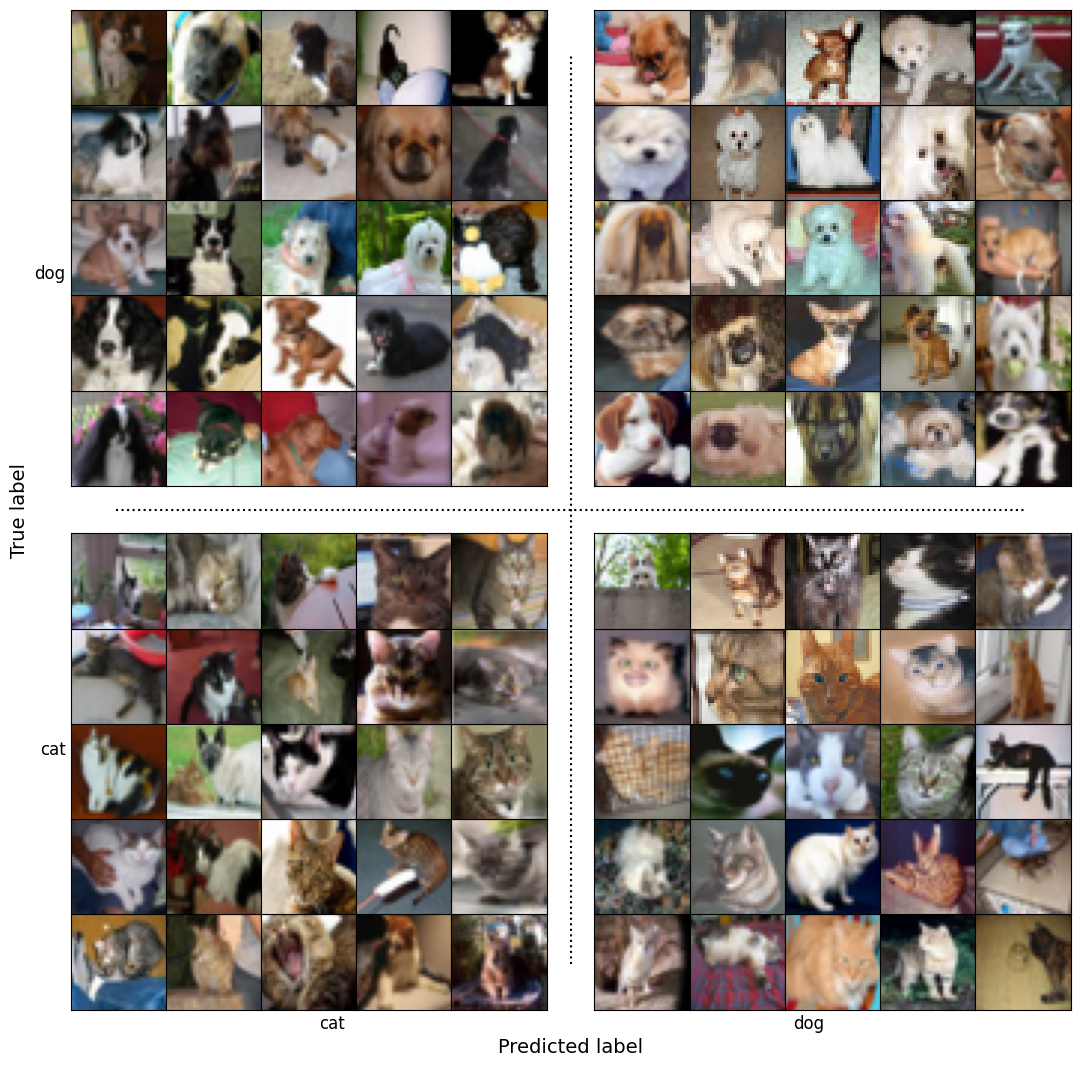

In [82]:
# Run function below to see the visualized confusion matrix (cats vs dogs) for model_mlp

# Change based on your observation of the confusion matrices
# For example, from the confusion matrix of model1, classes 3 (cat) and 5 (dog) seem to be confused.

cl_a, cl_b = 3, 5 # Integer class labels
plot_confused_classes(X_test, ys, outputs, classes, cl_a, cl_b)

# Convolutional network (15 points)
- complete the class definition below
- The network structure is provided. Feel free to modify it -- in which case, rename the class, and run the experiments below.
- The network structure is a sequence of three Conv2d, ReLU, Conv2D, ReLU, MaxPool2d, BatchNorm2d blocks.
- The final layers include two fully connected layers and an output layer with 10 units.

In [ ]:
class ConvModel(nn.Module):
    def __init__(self,lr,wd):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self,x):
        # forward propagate x through network
        ######## START YOUR CODE HERE (1 line)

        ######## END YOUR CODE HERE

    def loss(self,yhat,y,averaged=True):
        # compute cross-entropy loss between network output and true labels y
        # averaged over a batch
        ######## START YOUR CODE HERE (1-2 lines)

        ######## END YOUR CODE HERE

    def predict(self,X):
        # return the index of the highest output in the output layer
        ######## START YOUR CODE HERE (1 line)

        ######## END YOUR CODE HERE

    def configure_optimizers(self):
        # set up the Adam optimizer with default parameters and
        # model's learning rate and weight decay
        ######## START YOUR CODE HERE (1 line)

        ######## END YOUR CODE HERE

In [ ]:
# Visualize the model

lr = 1e-4
wd = 1e-1
model_cnn = ConvModel(lr,wd).to(device)

cnn_model_graph = draw_graph(
        model_cnn,
        input_size=(1,3,32,32),
        expand_nested=True,
        save_graph=True,
        filename="my_CNN_model",
        directory="./"
    )

# draw the model
plt.figure(figsize=(20, 25))
plt.imshow(mpimg.imread('my_CNN_model.png'))
plt.axis('off') # Turn off axis numbers and ticks
plt.show()

# Train the model
- under two sets of hyperparameters

In [ ]:
lr = 1e-4
wd = 1e-1
num_epochs = 30

model_cnn = ConvModel(lr,wd).to(device)
model_cnn,train_loss,val_loss = train_model(model_cnn,trainloader,valloader,num_epochs)
torch.save(model_cnn.state_dict(), 'model_cnn.pth')

# plot the validation and training loss curves
plot_loss_curves(num_epochs,train_loss,val_loss)

# run the trained model on test data and report
# accuracy, confusion matrix and classification report

X_test,ys,outputs = model_eval(model_cnn,testloader)

In [ ]:
# visual confusion matrix
# Change based on your observation of the confusion matrices

# For example, from the confusion matrix of model1, classes 3 (cat) and 5 (dog) seem to be confused.
cl_a, cl_b = 3, 5 # Integer class labels

plot_confused_classes(X_test, ys, outputs, classes,cl_a,cl_b)

In [ ]:
# hyperparameter set 2

lr = 1e-3
wd = 1e-3
num_epochs = 20

model_cnn2 = ConvModel(lr,wd).to(device)
model_cnn2,train_loss,val_loss = train_model(model_cnn2,trainloader,valloader,num_epochs)
torch.save(model_cnn2.state_dict(), 'model_cnn2.pth')

# plot the validation and training loss curves
plot_loss_curves(num_epochs,train_loss,val_loss)

# run the trained model on test data and report
# accuracy, confusion matrix and classification report

X_test,ys,outputs = model_eval(model_cnn,testloader)

In [ ]:
# visual confusion matrix
# Change based on your observation of the confusion matrices

# For example, from the confusion matrix of model1, classes 3 (cat) and 5 (dog) seem to be confused.
cl_a, cl_b = 3, 5 # Integer class labels
plot_confused_classes(X_test, ys, outputs, classes,cl_a,cl_b)

# Resnet18
- Resnet18 is a common Deep Learning model with a CNN architecture. We can access pretrained weights of this model
- The pretrained model is trained on Imagenet1k_V1 dataset.
- Resnet18 expects 224x224x3 images

In [ ]:
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# view the model
model_graph = draw_graph(
        resnet18,
        input_size=(64, 3,32,32),  # Example: batch size 64, input features 3,32,32
        expand_nested=True,  # Set to True to expand nested modules
        save_graph=True,     # Set to True to save the graph automatically
        filename="resnet18_graph", # Desired filename for the saved graph
        directory = "./",
        device='cuda'         # Specify the device (e.g., 'cpu' or 'cuda')
    )

# draw the model
plt.figure(figsize=(20, 60))
plt.imshow(mpimg.imread('resnet18_graph.png'))
plt.axis('off') # Turn off axis numbers and ticks
plt.show()

# Using pretrained Resnet18 to classify test images of CIFAR-10
- Since the final layer of Resnet18 has 1000 units (Imagenet1K has 1000 outputs), we need to add a new fully connected layer that goes from 1000 Resnet18 outputs to the 10 ouputs that CIFAR-10 has.
- We provide a function for evaluating the pretrained Resnet18 on the CIFAR-10 testloader
-  It calculates confusion matrix, and provides a classification report

In [ ]:
# make sure device is 'cuda' for this part
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

# Modify the final fully connected layer for 10 classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)
resnet18.to(device)

def model_eval_res(model,testloader):
    model.eval()
    X_test_list = [] # Use a list to store batches of test data
    with torch.no_grad():
        ys=[]
        outputs=[]
        for i, tdata in enumerate(testloader):
            tX,ty = tdata
            tX=tX.to(device)
            X_test_list.append(tX.detach().cpu().numpy())
            ty=ty.to(device)
            output = model(tX)
            output = torch.argmax(output, dim=1)
            ys.append(ty.detach().cpu().numpy())
            outputs.append(output.detach().cpu().numpy())

    X_test = np.concatenate(X_test_list)
    ys=np.hstack(ys)
    outputs= np.hstack(outputs)
    cm = sklearn.metrics.confusion_matrix(ys,outputs)
    print("****************************************************************************************")
    print("performance report")
    print(sklearn.metrics.classification_report(ys,outputs))
    print("confusion matrix:")
    disp = sklearn.metrics.ConfusionMatrixDisplay(cm,display_labels=classes)
    disp.plot()
    return X_test,ys,outputs

X_test,ys,outputs = model_eval_res(resnet18,testloader)

# Finetune Pretrained Resnet18 on CIFAR-10 (25 points)
Load a pre-trained Resnet18 model initialized with weights from Imagenet1K. Then,
add a fully connected layer at the end so final output will have 10 units.
 Set num_epochs. Define an optimizer (Adam with lr = 1e-3 and weight_decay=1e-3) (you can try other lr).
Define the loss function (nn.CrossEntropyLoss()).

Build the training loop
- Initialize train_loss and val_loss (which will hold training and validation set loss for each epoch)



 - for epoch in range(num_epochs)
    - for each batch (Xtr,ytr) in training set
     - - move Xtr and ytr to cuda device with .to(device)
       - zero out gradients in the optimizer
       -  compute output of network by calling resnet18(Xtr)
       -  compute loss using output and ytr
       - backpropagate the loss
       -  update the parameters (with .step() on optimizer)
       -  accumulate the training loss for this batch
    - store training loss for this epoch
    - compute validation set loss for this epoch (remember to turn off gradient update with torch.no_grad()) and remember to iterate over all the batches of the validation set
    
- return model, train_loss and val_loss


In [ ]:
# Load a pre-trained ResNet18 model
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final fully connected layer to match the number of classes in CIFAR-10
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

# Move the model to the appropriate device
resnet18 = resnet18.to(device)

# set num_epochs
num_epochs = 10
# Define the optimizer and loss function
optimizer = optim.Adam(resnet18.parameters(), lr=1e-3, weight_decay=1e-3) # You can adjust the learning rate
criterion = nn.CrossEntropyLoss()

def resnet18_train(resnet18,optimizer,criterion,num_epochs,trainloader,valloader):

    # START YOUR CODE HERE (20-24 lines)

    # END YOUR CODE HERE
    return resnet18, train_loss_resnet, val_loss_resnet

# Save the fine-tuned model
torch.save(resnet18.state_dict(), 'resnet18_cifar10.pth')

# Evaluate performance of model tuned on CIFAR-10 data

In [ ]:
plot_loss_curves(num_epochs,train_loss_resnet,val_loss_resnet)

X_test, ys, outputs = model_eval_res(resnet18,testloader)

In [ ]:
# For resnet model finetuned on cifar10

# Change based on your observation of the confusion matrices
# For example, from the confusion matrix of model1, classes 3 (cat) and 5 (dog) seem to be confused.
cl_a, cl_b = 5, 3 # Integer class labels

plot_confused_classes(X_test, ys, outputs, classes, cl_a, cl_b)

# Resnet training with data augmentation
- data augmentation is tricky. We have already selected the transforms for the training set. Make alterations to this sequence with care.
- For the test set, we resize the 32x32x3 images to 224x224x3 and normalize using the known tmean/tstd

In [ ]:
# set transforms
transform_train = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.RandomRotation(20),
     transforms.RandomHorizontalFlip(0.1),
     transforms.ColorJitter(brightness=0.1,contrast = 0.1 ,saturation =0.1 ),
     transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.1),
     transforms.ToTensor(),
     transforms.Normalize(tmean,tstd),
     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])
transform_test = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.ToTensor(),
     transforms.Normalize(tmean,tstd)])

# download and transform the  trainset and testset for training
trainset_aug = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
testset_aug = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

#split trainset into a train and a val set (90-10 split)
lengths_aug = [int(p * len(trainset_aug)) for p in [0.9,0.1]]
tr_aug,v_aug = torch.utils.data.random_split(trainset_aug,lengths_aug)
train_sampler_aug = torch.utils.data.SubsetRandomSampler(tr_aug.indices)
val_sampler_aug = torch.utils.data.SubsetRandomSampler(v_aug.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 64 # reduce batch size to 8, otherwise training time is quite long..
trainloader_aug = torch.utils.data.DataLoader(trainset_aug,batch_size=batch_size,sampler=train_sampler_aug)
valloader_aug = torch.utils.data.DataLoader(trainset_aug,batch_size=batch_size,sampler=val_sampler_aug)
testloader_aug = torch.utils.data.DataLoader(testset_aug, batch_size=batch_size)

print("Number of training batches = ",len(trainloader_aug))
print("Number of validation batches = ",len(valloader_aug))
print("Number of test batches = ",len(testloader_aug))

# Train resnet18 with augmented CIFAR-10 data

In [ ]:
# Load a pre-trained ResNet18 model
resnet18_aug = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final fully connected layer to match the number of classes in CIFAR-10
num_ftrs = resnet18_aug.fc.in_features
resnet18_aug.fc = nn.Linear(num_ftrs, 10)

# Move the model to the appropriate device
resnet18_aug = resnet18_aug.to(device)

# set num_epochs
num_epochs = 10

# Define the optimizer and loss function
optimizer = optim.SGD(resnet18_aug.parameters(), lr=1e-3, momentum=0.9) # You can adjust the learning rate
# add weight decay at 1e-3 for better results
# Adam optimizer tends to overfit
# trying to imitate https://www.kaggle.com/code/abdelrahmanhesham601/resnet-18-fine-tuning-on-cifar-10

criterion = nn.CrossEntropyLoss()

# Train the model on augmented data
resnet18_aug, train_loss_resnet, val_loss_resnet = resnet18_train(resnet18_aug,optimizer,criterion,num_epochs,
                                                                  trainloader_aug,valloader_aug)

In [ ]:
"""
To save memory, we rewrite the model_eval_res() and the corresponding plot_confused_classes()
"""
def model_eval_res(model, testloader):
    with torch.no_grad():
        ys = []
        outputs = []
        indices_list = []
        batch_start = 0

        for i, (tX, ty) in enumerate(testloader):
            tX = tX.to(device)
            ty = ty.to(device)

            output = model(tX)
            output = torch.argmax(output, dim=1)

            # save labels and preds
            ys.append(ty.detach().cpu().numpy())
            outputs.append(output.detach().cpu().numpy())

            # save the corresponding data indices
            batch_size = len(ty)
            batch_indices = list(range(batch_start, batch_start + batch_size))
            indices_list.extend(batch_indices)
            batch_start += batch_size

    ys = np.hstack(ys)
    outputs = np.hstack(outputs)
    indices = np.array(indices_list)

    # evaluate
    cm = sklearn.metrics.confusion_matrix(ys, outputs)
    print("****************************************************************************************")
    print("performance report")
    print(sklearn.metrics.classification_report(ys, outputs))
    print("confusion matrix:")
    disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot()

    return indices, ys, outputs  # return indices now rather than the raw data


def plot_confused_classes(X_test_indices, target_dataset, all_y_true, all_y_pred, classes, cl_a, cl_b):
    X_aa_indices = X_test_indices[(all_y_true == cl_a) & (all_y_pred == cl_a)]
    X_ab_indices = X_test_indices[(all_y_true == cl_a) & (all_y_pred == cl_b)]
    X_ba_indices = X_test_indices[(all_y_true == cl_b) & (all_y_pred == cl_a)]
    X_bb_indices = X_test_indices[(all_y_true == cl_b) & (all_y_pred == cl_b)]

    size = 5   # grid size inside each confusion block
    pad = 0.5  # spacing between quadrants
    total = 2 * size + pad  # logical grid size

    fig = plt.figure(figsize=(size*2, size*2))

    # Loop through quadrants
    for test_indices, (true_row, pred_col) in [
        (X_aa_indices, (0, 0)),  # true A, pred A
        (X_ab_indices, (0, 1)),  # true A, pred B
        (X_ba_indices, (1, 0)),  # true B, pred A
        (X_bb_indices, (1, 1)),  # true B, pred B
    ]:
        images=[target_dataset[test_index][0].cpu().numpy() for test_index in test_indices]
        for idx, image_data in enumerate(images[:size*size]):
            # Grid position in "data units"
            x = idx % size + pred_col * (size + pad)
            y = idx // size + true_row * (size + pad)

            # Normalize to figure coords [0,1]
            ax = fig.add_axes([x / total,
                               y / total,
                               1 / total,
                               1 / total])

            img = denormalize(image_data)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])

       # Add invisible overlay axis (in figure space)
    ax_main = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_main.set_xticks([ (size/2)/total, (size+pad+size/2)/total ])
    ax_main.set_xticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

    ax_main.set_yticks([ (size/2)/total, (size+pad+size/2)/total ])
    ax_main.set_yticklabels([classes[cl_a], classes[cl_b]], fontsize=12)

    ax_main.set_xlabel("Predicted label", fontsize=14)
    ax_main.set_ylabel("True label", fontsize=14)

    # Hide tick marks and spines
    ax_main.tick_params(axis='both', which='both', length=0)
    for spine in ax_main.spines.values():
        spine.set_visible(False)

    # Divider lines in normalized coords
    ax_main.plot([ (size+pad/2)/total, (size+pad/2)/total ], [0,1], "k:")
    ax_main.plot([0,1], [ (size+pad/2)/total, (size+pad/2)/total ], "k:")

    plt.show()

# Evaluate the model trained on augmented CIFAR-10 data

In [ ]:
plot_loss_curves(num_epochs,train_loss_resnet,val_loss_resnet)

X_test_indices, ys, outputs = model_eval_res(resnet18_aug,testloader_aug)

In [ ]:
plot_confused_classes(X_test_indices, testset_aug, ys, outputs, classes, cl_a, cl_b)

# Comment (50 points)
- performance difference between multilayer feedforward and convolutional neural nets
- difference in the number of parameters between the two classes of deep models
- impact of learning rate and weight decay choice on the feedforward networks
- impact of learning rate and weight decay choice on convolutional networks
- experiment with these two hyperparameters to achieve > 50% accuracy with feedforward networks, and > 80% accuracy with convolutional networks
- explain out-of-the-box performance of Restnet18 with pretrained weights on CIFAR-10
- explain the impact of tuning Resnet18 weights with CIFAR-10 data -- play with hyperparameters to get about 80% accuracy with this model
- explain the impact of tuning Resnet18 weights with CIFAR-10 data -- you should be able to get about 94% accuracy with this model with the suggested hyperparameters.


In [ ]:
# Comments here